In [4]:
import numpy as np
import matplotlib.pyplot as plt

# A New Approach for the Dynamics of Ultra-High-Frequency Data: The Model with Uncertainty Zones

This notebook attempts to reproduce the main findings and simulations of the paper from M. Mathieu Rosenbaum et M. Christian Y. Robert published in the Journal of Financial Econometrics, 2011, Vol. 9, No. 2, 344-366.

## Model

In our notebook we stick to the same notation as in the paper. For more details please refer to it.

Let $(X_{t})_{t \geq 0}$ be the efficient price of the asset. Let $(\Omega, (\mathcal{F}_{t})_{t\geq 0},\mathbb{P})$ be the filtered probability space, and $(W_{t})_{t\geq 0}$ a standard $\mathcal{F}$-Brownian motion. We assume that the logarithm of the price is $\mathcal{F}_{t}$-adapted continuous semi-martingale that follows the equation:

$$
Y_{t} = \log(X_{t}) = \log(X_{0}) + \int_{0}^{t} a_{u}dt + \int_{0}^{t}\sigma_{u-} dW_{u}
$$

We define the tick grid as $\{k\alpha, k\in\mathbb{N}\}$ with $\alpha$ the tick size. We now define the uncertainty zones in between the mid-points of the tick grid as $\mathcal{U}_{k} = [0,+\infty) \times (d_{k}, u_{k})$ with:

$$
d_{k} = \left(k + \frac{1}{2} - \eta\right)\alpha \quad\text{and}\quad u_{k} = \left(k+\frac{1}{2}+\eta\right) \alpha, \quad \text{with}\quad 0<\eta<1
$$

Let us now define the sequence of exit times form uncertainty zones $(\tau_{i})_{i\geq 0}$. We take $\tau_{0} = 0$ and we assume that we start at the tick $k_{0} = X_{0}^{(\alpha)} / \alpha$, $X_{0}^{(\alpha)}$ being $X_{0}$ rounded to the nearest multiple of $\alpha$. Let $\tau_{1}$ be the first exit time from the set $(d_{k_{0}-1}, u_{k_{0}})$.

We then define recursively $\tau_{i+1}$ as the exit time of $(X_t)_{t>\tau_i}$ of the uncertainty zone $(d_{k_i-L_i}, u_{k_i+L_i -1})$, where $k_i=X_{\tau_i}^{(\alpha)} / \alpha$ and $L_i$ representing the absolute value in number of ticks of the price jump between the $i^{th}$ and the $(i + 1)^{th}$ transaction leading to a price change.

$$
\tau_{i+1} = \inf\left\{t: t>\tau_i, \quad X_t = (k_i -L_i-\frac{1}{2}+\eta)\alpha \quad \text{or}\quad X_t = (k_i +L_i-\frac{1}{2}+\eta)\alpha\right\}
$$

We'll assume here that the price can only jump from one tick to one consecutive tick ($L_i = 1$). We also assume that the transactions which lead to a change of price are exactly made at the times $\tau_i$. We call by $(P_{\tau_i})_{i\in\mathbb{N}}$ the prices of these transactions.



From this we can retrieve the efficient price at times $\tau_i$:

$$
X_{\tau_i} = P_{\tau_i} - sign(P_{\tau_i} - P_{\tau_{i-1}})(\frac{1}{2} - \eta)\alpha
$$

## Simulation

We take the simple model of the paper:

$$
dX_t = \sigma_tX_tdW_t, \quad X_0 = 100, \quad t\in[0, 100]
$$

where $(\sigma_t)_{t\in[0, 1]}$ is a deterministic function.
The interval $[0, 1]$ corresponds to one trading day of 8h.

In [44]:
# Parameters
alpha = 0.05
eta = 0.05
X0 = 100
mesh = 3600 * 8 * 10
T = 1
dt = T / mesh

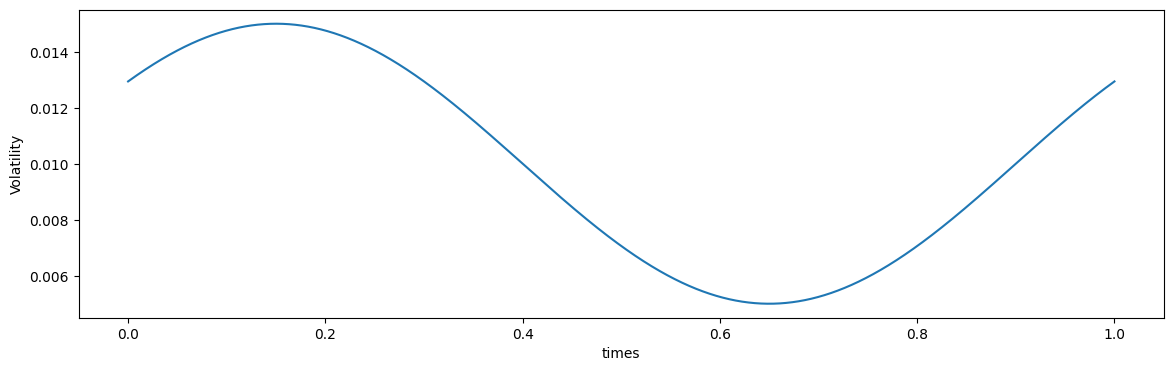

In [42]:
def sigma(x: np.ndarray) -> np.ndarray:
    return (1 + np.sin(2 * np.pi * (x + 0.1))) * (0.01 / 2) + 0.005

t = np.arange(0, T, dt)
plt.figure(figsize=(14, 4))
plt.xlabel('times')
plt.ylabel('Volatility')
plt.plot(t, sigma(t))


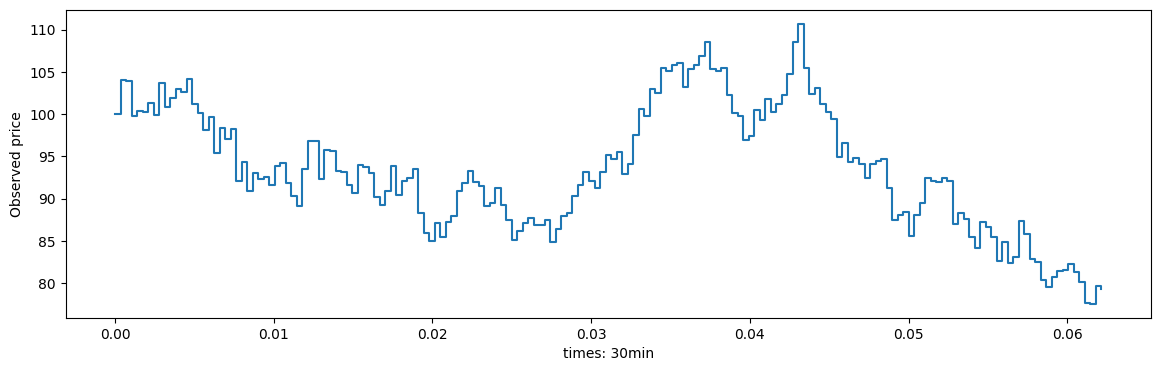

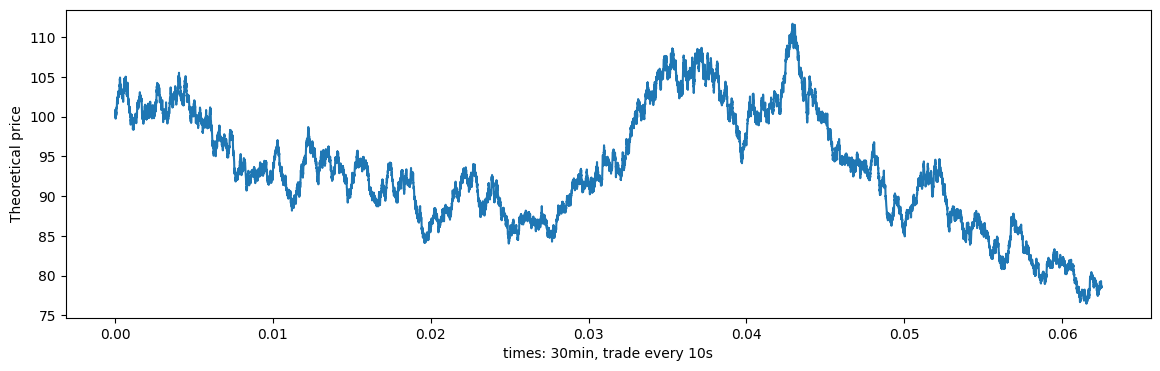

In [78]:
def generate_returns(t):
    ''' Generates the returns under the model of the paper
    '''
    
    S = np.zeros(mesh+1)
    S[0] = X0

    dB = np.random.normal(0, np.sqrt(dt), mesh)
    for i in range(mesh):
        dS = sigma(t[i]) * S[i] * dB[i]
        S[i+1] = S[i] * np.exp(dS)

    dX = np.diff(S) / S[:-1]
    
    X = np.cumsum(dX)

    return S, dX, X

S, dX, X = generate_returns(t)
plt.figure(figsize=(14, 4))
plt.xlabel('times: 30min')
plt.ylabel('Observed price')
plt.step(t[:int(mesh/16)][::100], np.round(S[:int(mesh/16)][::100] / alpha) * alpha, where='post')

plt.figure(figsize=(14, 4))
plt.xlabel('times: 30min, trade every 10s')
plt.ylabel('Theoretical price')
plt.plot(t[:int(mesh/16)], S[:int(mesh/16)])



In [ ]:
def efficient_price(P: np.ndarray, eta: float = 0.05) -> np.ndarray:
    return P - np.sign(P - P[:-1]) * (1/2 - eta) * alpha